In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]

In [8]:
X.columns

Index(['pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6', 'pixel7',
       'pixel8', 'pixel9', 'pixel10',
       ...
       'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779', 'pixel780',
       'pixel781', 'pixel782', 'pixel783', 'pixel784'],
      dtype='object', length=784)

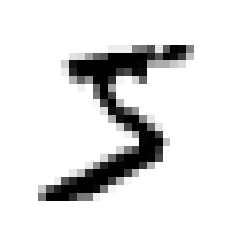

In [5]:
import matplotlib as mpl
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [6]:
y= y.astype(np.uint8)

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a Binary Classifier

In [8]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits.
y_test_5 = (y_test == 5)

In [9]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(random_state=42)
sgd.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [10]:
sgd.predict([some_digit])

array([ True])

## Performance Measures

In [11]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [12]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd, X_train, y_train_5, cv=3)

In [13]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

### Precision and Recall
Presision is the ratio of true positives to the sum of true positives and false positives.
$$P=\frac{TP}{TP+FP}$$
Recall is the ratio of true positives to the sum of true positives and false negatives.
$$R=\frac{TP}{TP+FN}$$

In [16]:
from sklearn.metrics import precision_score, recall_score
pr = precision_score(y_train_5, y_train_pred)
re = recall_score(y_train_5, y_train_pred)
pr, re

(0.8370879772350012, 0.6511713705958311)

When the model claims an image represents a 5, it is correct only 83.7% of the time. More‐
over, it only detects 65.1% of the 5s.

### $F_1$ Score
The F1 score is the harmonic mean of precision and recall.
$$ F_1=2\frac{P \times R}{P+R}$$

In [17]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

### Precision/Recall Tradeoff
Increasing Precision decreases Recall and vice versa.
<br>
<img src = "img/03_01.png">

In [18]:
sgd.decision_function([some_digit])

array([2164.22030239])

In [23]:
threshold = 3000
y_scores = sgd.decision_function([some_digit])
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [25]:
y_scores = cross_val_predict(sgd, X_train, y_train_5, cv=3,
method="decision_function")

Now with these scores you can compute precision and recall for all possible thresh‐
olds using the `precision_recall_curve()` function:

In [26]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [29]:
precisions, recalls, thresholds

(array([0.09040123, 0.09038606, 0.09038757, ..., 1.        , 1.        ,
        1.        ]),
 array([1.00000000e+00, 9.99815532e-01, 9.99815532e-01, ...,
        3.68935621e-04, 1.84467810e-04, 0.00000000e+00]),
 array([-106527.45300471, -105763.22240074, -105406.2965229 , ...,
          38871.26391927,   42216.05562787,   49441.43765905]))

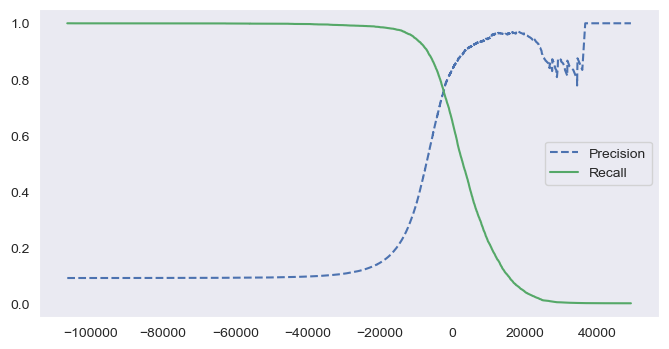

In [41]:
sns.set_style("whitegrid")
# sns.set_theme({"axes.grid": False})
# sns.reset_orig
# mpl.rc_file_defaults()
sns.set_style("darkgrid", {"axes.grid": False})
plt.figure(figsize=(8, 4))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.legend(loc="best")

Text(0.5, 1.0, 'Precision and Recall for different threshold values')

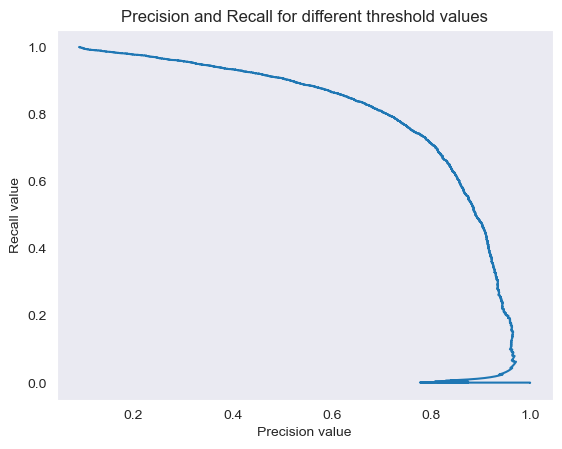

In [52]:
plt.plot(precisions, recalls)
plt.xlabel("Precision value")
plt.ylabel("Recall value")
plt.title("Precision and Recall for different threshold values")

In [44]:
threshold_90_precision =thresholds[np.argmax(precisions >= 0.90)] 

To make predictions (on the training set for now), instead of calling the classifier’s
`predict()` method, you can just run this code:

In [45]:
y_train_pred_90 = (y_scores >= threshold_90_precision)


In [46]:
precision_score(y_train_5, y_train_pred_90), recall_score(y_train_5, y_train_pred_90)

(0.9000345901072293, 0.4799852425751706)

Great, you have a 90% precision classifier ! As you can see, it is fairly easy to create a
classifier with virtually any precision you want: just set a high enough threshold, and
you’re done. However, recall becomes low.

### ROC Curve

The ROC curve plots the *true positive rate* (another name
for recall) against the *false positive rate*. The FPR is the ratio of negative instances that
are incorrectly classified as positive. It is equal to one minus the *true negative rate*,
which is the ratio of negative instances that are correctly classified as negative. The
TNR is also called **specificity**. Hence the ROC curve plots **sensitivity (recall) versus
1 – specificity**.

In [47]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

No handles with labels found to put in legend.


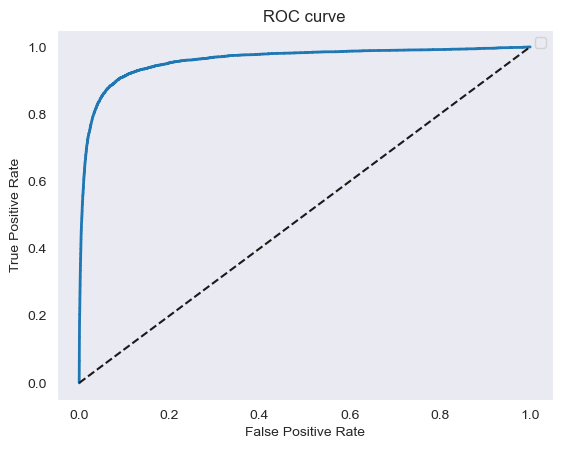

In [60]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC curve")
    plt.legend(loc="best")

plot_roc_curve(fpr, tpr)

The dotted line represents the ROC curve of a purely
random classifier; a good classifier stays as far away from that line as possible (toward
the top-left corner). <br>
One way to compare classifiers is to measure the *area under the curve (AUC)*. A per‐
fect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will
have a ROC AUC equal to 0.5. 

In [50]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

>Since the ROC curve is so similar to the precision/recall (or PR)
curve, you may wonder how to decide which one to use. As a rule
of thumb, you should prefer the PR curve whenever the positive
class is rare or when you care more about the false positives than
the false negatives, and the ROC curve otherwise. For example,
looking at the previous ROC curve (and the ROC AUC score), you
may think that the classifier is really good. But this is mostly
because there are few positives (5s) compared to the negatives
(non-5s). In contrast, the PR curve makes it clear that the classifier
has room for improvement (the curve could be closer to the topright corner).

In [54]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
method="predict_proba")

In [67]:
y_probas_forest

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       ...,
       [0.02, 0.98],
       [0.92, 0.08],
       [0.94, 0.06]])

To plot a ROC curve, you need scores, not probabilities. A simple solution is to
use the positive class’s probability as the score:

In [55]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

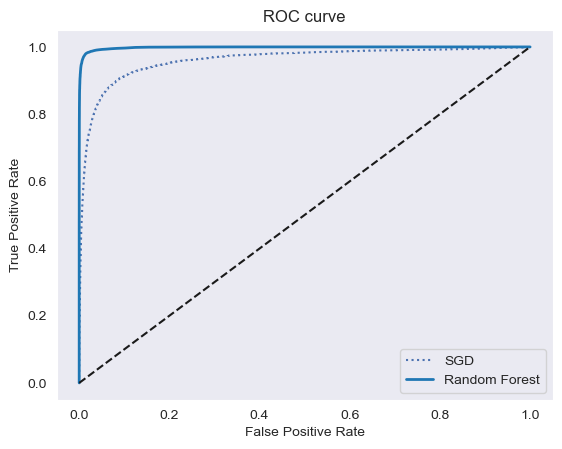

In [61]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [62]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [66]:
y_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)

In [68]:
recall_score(y_train_5, y_pred_forest), precision_score(y_train_5, y_pred_forest)

(0.8662608374838591, 0.9905083315756169)

## Multiclass Classification

In [69]:
sgd.fit(X_train, y_train)
sgd.predict([some_digit])

array([3], dtype=uint8)

In [74]:
y_pred = sgd.predict(X_train)

In [72]:
some_digit_scores = sgd.decision_function([some_digit])
some_digit_scores

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [73]:
np.argmax(some_digit_scores)

3

In [77]:
y_train, y_pred

(array([5, 0, 4, ..., 5, 6, 8], dtype=uint8),
 array([3, 0, 4, ..., 5, 6, 8], dtype=uint8))

In [98]:
c_mat= confusion_matrix(y_train, y_pred)

In [89]:
recall_score(y_train, y_pred, average=None), precision_score(y_train, y_pred, average=None)

(array([0.90545332, 0.96143578, 0.82292716, 0.91942587, 0.79596029,
        0.79653201, 0.91078067, 0.90518755, 0.8971116 , 0.87123886]),
 array([0.98512123, 0.97738239, 0.93479504, 0.78226478, 0.96313173,
        0.8636    , 0.97029703, 0.94500917, 0.66772675, 0.83220938]))

>If you want to force ScikitLearn to use one-versus-one or one-versus-all, you can use
the OneVsOneClassifier or OneVsRestClassifier classes. Simply create an instance
and pass a binary classifier to its constructor.

In [90]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5], dtype=uint8)

In [91]:
len(ovo_clf.estimators_)

45

In [92]:
cross_val_score(sgd, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

**Scaling the Input increases the accuracy**

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd, X_train_scaled, y_train, cv=3, scoring="accuracy")

## Error Analysis

<Figure size 1000x1000 with 0 Axes>

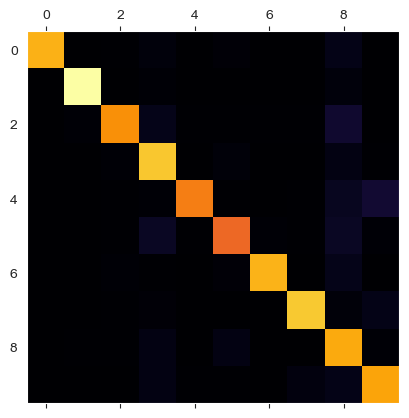

In [104]:
# y_train_pred = cross_val_predict(sgd, X_train_scaled, y_train, cv=2)
# conf_mx = confusion_matrix(y_train, y_train_pred)
# conf_mx
plt.figure(figsize=(10, 10))
plt.matshow(c_mat, cmap='inferno');

<Figure size 1000x1000 with 0 Axes>

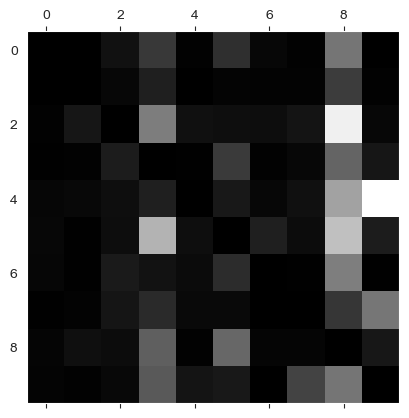

In [111]:
new_c_map = c_mat/c_mat.sum(axis=1)
np.fill_diagonal(new_c_map, 0)
plt.figure(figsize=(10, 10))
plt.matshow(new_c_map, cmap='gray');

Analyzing the confusion matrix can often give you insights on ways to improve your
classifier. Looking at this plot, it seems that your efforts should be spent on reducing
the false 8s. For example, you could try to gather more training data for digits that
look like 8s (but are not) so the classifier can learn to distinguish them from real 8s.
Or you could engineer new features that would help the classifier—for example, writ‐
ing an algorithm to count the number of closed loops (e.g., 8 has two, 6 has one, 5 has
none). Or you could preprocess the images (e.g., using Scikit-Image, Pillow, or
OpenCV) to make some patterns stand out more, such as closed loops.

## Multilabel Classification
A classification system that outputs multiple
binary tags is called a multilabel classification system.

In [117]:
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [118]:
knn_clf.predict([some_digit])

array([[False,  True]])

## Multioutput Classification
The last type of classification task we are going to discuss here is called multioutputmulticlass classification (or simply multioutput classification). It is simply a generaliza‐
tion of multilabel classification where each label can be multiclass (i.e., it can have
more than two possible values). <br>
To illustrate this, let’s build a system that removes noise from images. It will take as
input a noisy digit image, and it will (hopefully) output a clean digit image, repre‐
sented as an array of pixel intensities, just like the MNIST images. 

In [119]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

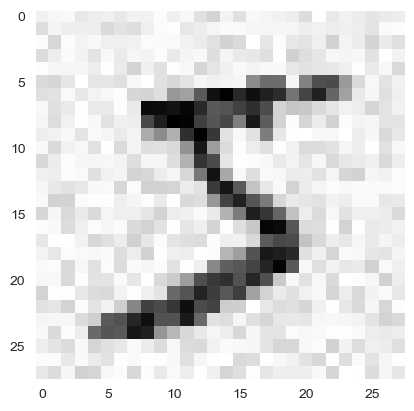

In [128]:
plt.imshow(X_train_mod[0].reshape(28, 28), cmap='Greys')

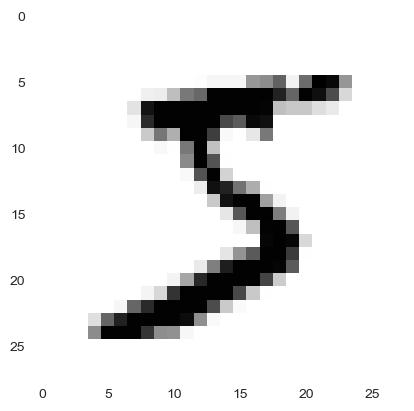

In [130]:
plt.imshow(y_train_mod[0].reshape(28, 28), cmap='Greys')

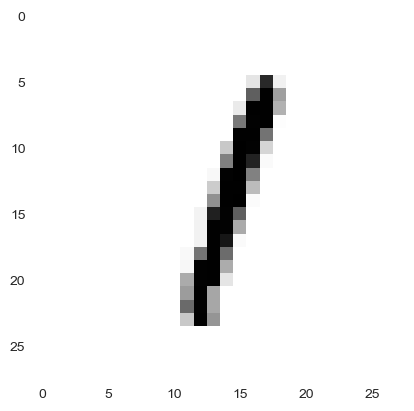

In [131]:
knn_clf.fit(X_train_mod, y_train_mod)
some_index = 5
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plt.imshow(clean_digit.reshape(28, 28), cmap='Greys')

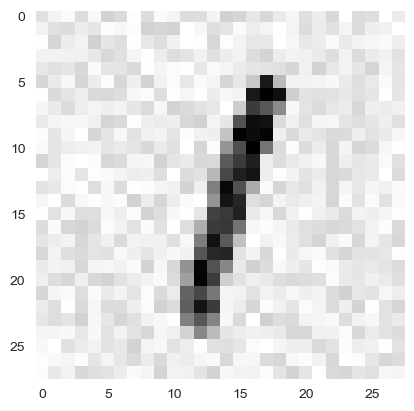

In [133]:
plt.imshow(X_test_mod[some_index].reshape(28, 28), cmap='Greys')